In [19]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector
from keras.optimizers import Adam
import matplotlib.pyplot as plt




 # data loading and normilization

In [20]:
df = pd.read_csv("adairsim_trajectory.csv")[['POS_X', 'POS_Y', 'POS_Z']]
print(f"loaded {len(df)} data points")
print(df.head())  

def normalize(data):
    minVal = np.min(data, axis=0)
    maxVal = np.max(data, axis=0)
    return (data - minVal) / (maxVal - minVal), minVal, maxVal

def makeWindows(data, windowSize=15):
    numWindows = len(data) // windowSize
    return np.array(np.split(data[:numWindows * windowSize], numWindows))

normalizedData, dataMin, dataMax = normalize(df.values)
windows = makeWindows(normalizedData)

print(f"Created {len(windows)} windows of shape {windows[0].shape}")


loaded 54000 data points
   POS_X  POS_Y      POS_Z
0    0.0    0.0 -29.590242
1    0.0    0.0 -29.591192
2    0.0    0.0 -29.592297
3    0.0    0.0 -29.593561
4    0.0    0.0 -29.594858
Created 3600 windows of shape (15, 3)


# building the model

In [21]:
def buildModel(windowSize=15, features=3):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(windowSize, features)),
        RepeatVector(windowSize),
        LSTM(features, activation='relu', return_sequences=True),
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model = buildModel()


c:\Users\KELLYC40\Downloads\UAVSTUFF\UAV-Trajectory-Prediction-main\AirEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 # training/test split and training

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1278 - val_loss: 0.0559
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0377 - val_loss: 0.0188
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.0032
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 9.4005e-04
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3294e-04 - val_loss: 8.4139e-04
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5697e-04 - val_loss: 6.3663e-04
Epoch 9/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7549e-04 - val_loss: 6.9730e-04
Epoch 10/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5892e-04 - val_loss: 5.7497e-04
Epoch 11/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3040e-04 - val_loss: 5.4240e-04
Epoch 12/200
36/36

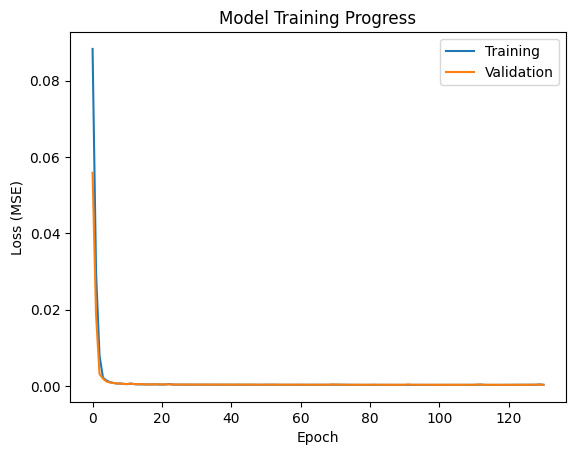

In [22]:
from keras.callbacks import EarlyStopping

splitIdx = int(0.8 * len(windows))
trainData = windows[:splitIdx]
testData = windows[splitIdx:]

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    trainData,
    trainData,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Training Progress')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# anomalies detection and injection

In [23]:
import numpy as np
import random
from scipy.interpolate import interp1d

def bounded_noise(window, low=0.2, high=1.0):
    out = window.copy()
    for i in range(1, len(window)):
        direction = np.random.normal(size=3)
        direction /= np.linalg.norm(direction)
        length = np.random.uniform(low, high)
        out[i] = out[i-1] + direction * length
    return out

def pattern_switch(window, amp=0.3, freq=3*np.pi):
    out = window.copy()
    mid = len(window) // 2
    t   = np.linspace(0, 1, len(window)-mid)
    wig = amp * np.sin(freq * t)
    out[mid:, 0] += wig
    return out

def apply_speed_warping(traj, factor):
    T = len(traj)
    n_warp = int(T / factor)
    n_warp = max(2, min(n_warp, T))
    t_original = np.linspace(0, 1.5, T)
    t_warped   = np.linspace(0, 1.5, n_warp)
    interp = interp1d(t_warped, traj[:n_warp], axis=0, fill_value="extrapolate")
    return interp(t_original)

anomalousData   = testData.copy()
numWindows      = len(anomalousData)
anomalyCount    = int(0.2 * numWindows)
anomalyIndices  = random.sample(range(numWindows), anomalyCount)

for idx in anomalyIndices:
    typ = random.choice(["noise", "switch", "warp"])
    if typ == "noise":
        anomalousData[idx] = bounded_noise(anomalousData[idx], low=0.2, high=1.0)
    elif typ == "switch":
        anomalousData[idx] = pattern_switch(anomalousData[idx], amp=0.3, freq=3*np.pi)
    else:  
        factor = np.random.uniform(0.8, 1.2)
        anomalousData[idx] = apply_speed_warping(anomalousData[idx], factor)

def findAnomalies(data, model, threshold=0.0008):
    reconstructions = model.predict(data)
    errors = np.mean((data - reconstructions)**2, axis=(1,2))
    return errors > threshold, errors

trueAnomalies = np.zeros(numWindows, dtype=bool)
trueAnomalies[anomalyIndices] = True

import time, os, torch

t0_wall = time.time()
t0_cpu  = time.process_time()

try:
    import resource
    mem0 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
except ImportError:
    import psutil
    mem0 = psutil.Process(os.getpid()).memory_info().rss

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    gpu0 = torch.cuda.memory_allocated()

predFlags, _ = findAnomalies(anomalousData, model, threshold=0.005)

t1_wall = time.time()
t1_cpu  = time.process_time()

try:
    mem1 = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
except:
    mem1 = psutil.Process(os.getpid()).memory_info().rss

if torch.cuda.is_available():
    gpu_peak = torch.cuda.max_memory_allocated()

wall = t1_wall - t0_wall
cpu  = t1_cpu  - t0_cpu
ram  = (mem1 - mem0) / 1024**2
gpu  = ((gpu_peak - gpu0) / 1024**2) if torch.cuda.is_available() else 0.0
avg  = wall / numWindows

print("=== Anomaly Detection Profile ===")
print(f"Total windows     : {numWindows}")
print(f"Wall-clock        : {wall:.3f}s  ({avg:.5f}s/window)")
print(f"CPU time          : {cpu:.3f}s")
print(f"RAM Δ             : {ram:.1f} MB")
if torch.cuda.is_available():
    print(f"GPU Δ peak        : {gpu:.1f} MB")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
=== Anomaly Detection Profile ===
Total windows     : 720
Wall-clock        : 0.307s  (0.00043s/window)
CPU time          : 0.109s
RAM Δ             : 0.5 MB


# confusion matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


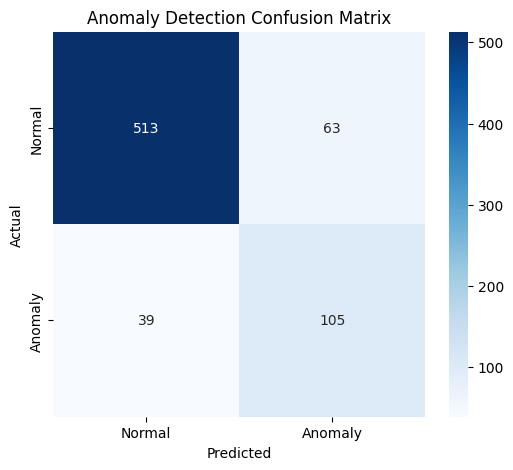

Accuracy : 0.858
Precision: 0.625
Recall   : 0.729
F1 Score : 0.673


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

anomalyPredictions, _ = findAnomalies(anomalousData, model)
trueLabels = trueAnomalies.astype(int)
predLabels = anomalyPredictions.astype(int)

cm = confusion_matrix(trueLabels, predLabels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Anomaly Detection Confusion Matrix')
plt.show()

acc   = accuracy_score(trueLabels, predLabels)
prec  = precision_score(trueLabels, predLabels)
rec   = recall_score(trueLabels, predLabels)
f1    = f1_score(trueLabels, predLabels)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
